In [1]:
from models import DisoGraph
from layers import modify_with_lora, LoRAConfig
from transformers import EsmModel, EsmTokenizer
import torch

/home/xie/anaconda3/envs/pytorch_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load pre-trained ESM-2 model and tokenizer
tokenizer = EsmTokenizer.from_pretrained("facebook/esm2_t33_650M_UR50D")
model = EsmModel.from_pretrained("facebook/esm2_t33_650M_UR50D")

class_model = DisoGraph(config=model.config)
class_model.encoder = model
model = class_model
del class_model

# Freeze ESM model parameters
for (param_name, param) in model.encoder.named_parameters():
    param.requires_grad = False

# Add LoRA to the model
config = LoRAConfig()
model = modify_with_lora(model, config)

model.load_state_dict(torch.load("DisoGraph_LoRA_params.pth"))

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_2814703/1385593998.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`.

<All keys matched successfully>

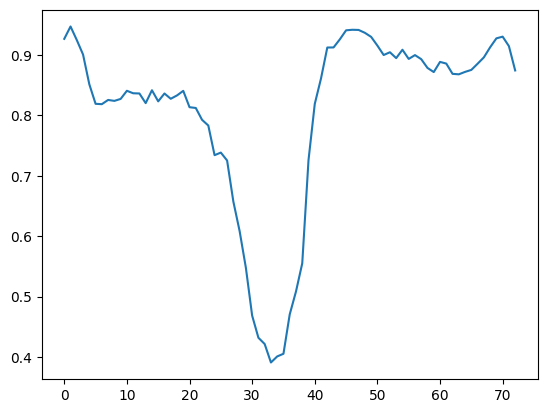

In [10]:
'''
    # Predict on a single sequence
'''

sequence = "MVLRQLSRKASVKVSKTWSGTKKRAQRILIFLLEFLLDFCTGEDSVDGKKRQRHSGLTEQTYSALPEPKAT"
with torch.no_grad():
    inputs = tokenizer(sequence, return_tensors="pt")
    outputs = model(**inputs)
    probs = torch.softmax(outputs.logits, dim=-1)
    predictions = torch.argmax(probs, dim=-1)

import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.array(probs[0][:,1].cpu()))

In [13]:
''' 
    # Predic on multiple sequences in a fasta file 
'''

from utils import read_fasta_to_dataframe, create_dataset, get_evaluate_results
from transformers import DataCollatorForTokenClassification
from torch.utils.data import DataLoader
from tqdm import tqdm

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.eval()
modle = model.to(device)
data_collator = DataCollatorForTokenClassification(tokenizer)

fasta_file = "datasets/DM1229.fasta"
test_df = read_fasta_to_dataframe(fasta_file)
test_set=create_dataset(tokenizer,list(test_df['sequence']),list(test_df['label']))
test_dataloader = DataLoader(test_set, batch_size=8, shuffle = False, collate_fn = data_collator)
predictions = []
padded_labels = []
scores = []
with torch.no_grad():
    for batch in tqdm(test_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        padded_labels += batch['labels'].tolist()
        predictions += model(input_ids, attention_mask=attention_mask, labels=None).logits.argmax(dim=-1).tolist()
        score = torch.softmax(model(input_ids, attention_mask=attention_mask, labels=None).logits, dim=-1)
        scores += score[:,:,1].tolist()
# to make it easier we flatten both the label and prediction lists
def flatten(l):
    return [item for sublist in l for item in sublist]
 # flatten and convert to np array for easy slicing in the next step
predictions = np.array(flatten(predictions))
scores = np.array(flatten(scores))
padded_labels = np.array(flatten(padded_labels))
# Filter out all invalid (label = -100) values
predictions = predictions[padded_labels!=-100]
scores = scores[padded_labels!=-100]
padded_labels = padded_labels[padded_labels!=-100]

# Calculate metirics
results, confusion_matrix = get_evaluate_results(y_true=padded_labels, y_pred=scores, y_pred_classes=predictions)
print('Test-set performance:')
print(results)
print('Confusion matrix:')
print(confusion_matrix)

100%|██████████| 154/154 [06:02<00:00,  2.36s/it]


Test-set performance:
{'Accuracy': 0.9409676816738277, 'AUC': 0.923264949439509, 'Sn': 0.5500998553818608, 'Sp': 0.9820848380354898, 'BACC': 0.7660923467086753, 'MCC': 0.6179871643503184, 'F1': 0.6395004403170282, 'AUCPR': 0.7113644946135478}
Confusion matrix:
        0      1
0  271133   4946
1   13066  15976
